In [1]:
!pip install pytorch-model-summary

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, FastICA

from sklearn.datasets import fetch_lfw_people
from pytorch_model_summary import summary
import logging

In [3]:
logger = logging.getLogger()
old_level = logger.level

# Utility Functions and Data

In [4]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    logger.setLevel(100)
    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [5]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((128, 128)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [6]:
standardize = lambda x: transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))(x)

In [7]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Parameters

IMAGE_SHAPE = (3, 128, 128)
LATENT_DIMS = 64
SH = IMAGE_SHAPE[1] // 16

In [9]:
# Load Data

lfw_people = fetch_lfw_people("./lfw/", resize=1)
data = dataset_loader("/content/lfw/lfw_home/lfw_funneled")

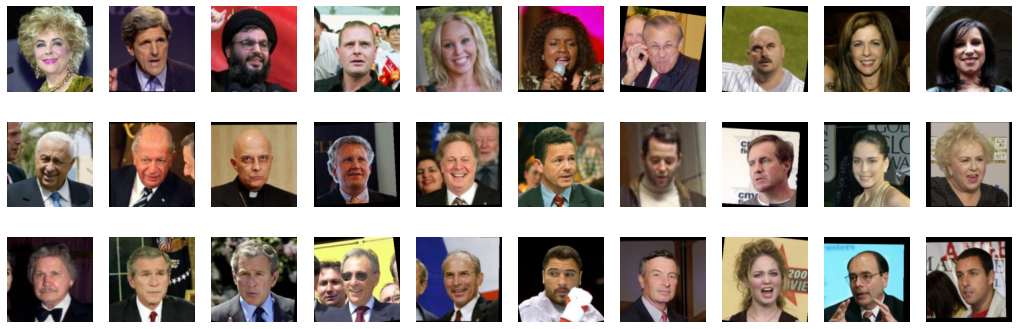

In [10]:
# A Data batch

X = next(iter(data))[0]
plot_image_samples(X)

# VAE Architecture

In [11]:
class residualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(residualBlock, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels, track_running_stats=False))
        else:
          self.skip = None

        self.block = nn.Sequential(nn.BatchNorm2d(in_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels, out_channels, 3, padding=1)
                                   )   

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out)

        return out

class EncoderConv(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(EncoderConv, self).__init__()
        
        self.latents = latents
        self.c = c
        
        size = self.c * np.array([2,4,8,16], dtype = np.intc)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_down1 = residualBlock(3, size[0])
        self.dconv_down2 = residualBlock(size[0], size[1])
        self.dconv_down3 = residualBlock(size[1], size[2])
        self.dconv_down4 = residualBlock(size[2], size[3])
        self.dconv_down5 = residualBlock(size[3], size[3])
        
        self.fc_mu = nn.Linear(in_features=size[3]*SH*SH, out_features=self.latents)
        self.fc_logvar = nn.Linear(in_features=size[3]*SH*SH, out_features=self.latents)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        x = self.maxpool(x)
        
        x = self.dconv_down5(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        
        return x_mu, x_logvar

class DecoderConv(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(DecoderConv, self).__init__()
        
        self.latents = latents
        self.c = c
        
        size = self.c * np.array([2,4,8,16], dtype = np.intc)
        
        self.fc = nn.Linear(in_features=self.latents, out_features=(self.c*16)*SH*SH)
          
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = residualBlock(size[3], size[3])
        self.dconv_up3 = residualBlock(size[3], size[2])
        self.dconv_up2 = residualBlock(size[2], size[1])
        self.dconv_up1 = residualBlock(size[1], size[0])
        self.conv_last = nn.Conv2d(size[0], 3, 1)
        
        
    def forward(self, x):        
        x = self.fc(x)

        x = x.view(x.size(0), self.c*16, SH, SH) # unflatten batch of feature vectors to a batch of multi-channel feature maps

        x = self.upsample(x)
        x = self.dconv_up4(x)
        
        x = self.upsample(x)    
        x = self.dconv_up3(x)
      
        x = self.upsample(x)   
        x = self.dconv_up2(x)
        
        x = self.upsample(x)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

class VariationalAutoencoder(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderConv(latents, c)
        self.decoder = DecoderConv(latents, c)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu


        self.kl_loss = None
        self.reconstr_loss = None

def vae_loss(recon_x, x, mu, logvar, variational_beta):
    loss_rec = F.mse_loss(recon_x, x) 
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = loss_rec + variational_beta * kldivergence
    
    return loss


# Load VAE

In [12]:
# Instantiate Model

model = VariationalAutoencoder(latents=LATENT_DIMS).to(device)
print(summary(model, torch.zeros((1, *IMAGE_SHAPE)).to(device), show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
     EncoderConv-1     [1, 3, 128, 128]         675,446         675,446
     DecoderConv-2              [1, 64]         379,915         379,915
Total params: 1,055,361
Trainable params: 1,055,361
Non-trainable params: 0
------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
# Load Trained State

! wget https://raw.githubusercontent.com/aliicee3/LOGML2021-Learning-Latent-Geometries/main/bestModel_ConvVae.pt
model.load_state_dict(torch.load("bestModel_ConvVae.pt"))

--2021-07-14 10:47:25--  https://raw.githubusercontent.com/aliicee3/LOGML2021-Learning-Latent-Geometries/main/bestModel_ConvVae.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4279307 (4.1M) [application/octet-stream]
Saving to: ‘bestModel_ConvVae.pt’

bestModel_ConvVae.p 100%[===================>]   4.08M  --.-KB/s    in 0.1s    

2021-07-14 10:47:26 (38.0 MB/s) - ‘bestModel_ConvVae.pt’ saved [4279307/4279307]



<All keys matched successfully>

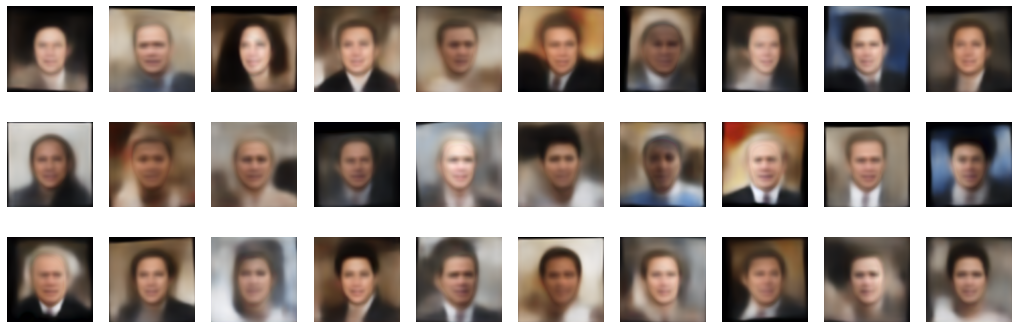

In [14]:
# Generate Images

imgs = model.decoder(torch.randn((32, LATENT_DIMS)).to(device)).detach().cpu()
plot_image_samples(imgs)

# Manifold Visualization

In [15]:
# Visualizing Latent Space

def plot_manfold(model, data, N, N_sample=3, algo="pca", func="linear"):
    """
    Args:
    - model: Trained Model
    - N: No of Images
    - N_sample: No. of Sample per Image
    - data: Dataloader
    - algo: PCA/Fast-ICA
    - func: Act as Kernel for PCA and G-Function for ICA.
            for PCA: {linear, poly, rbf, sigmoid, cosine}
            for ICA: {logcosh, exp, cube}
    """

    # Sampling Images
    temp = [next(iter(data)) for _ in range(N//data.batch_size + 1)]
    X = torch.vstack([x[0] for x in temp])
    Y = torch.hstack([x[1] for x in temp])

    # Forward Pass through Encoder
    mu_, _log_var = model.encoder(X.to(device))

    # Sampling from Normal Disitrbution using predicted Parameters
    embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()
    embedding_class = torch.hstack([Y for _ in range(N_sample)]).detach().cpu().numpy()

    # Dimensionality Reduction
    low_dim_embeddings = None
    if algo == "pca":
        low_dim_embeddings = KernelPCA(n_components=2, kernel=func).fit_transform(embeddings)
    else:
        low_dim_embeddings = FastICA(n_components=2, fun=func).fit_transform(embeddings)

    # Plotting Principle Components
    plt.figure(figsize=(16,8))
    plt.scatter(x = low_dim_embeddings[:,0], 
                y = low_dim_embeddings[:, 1], 
                alpha=0.6)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

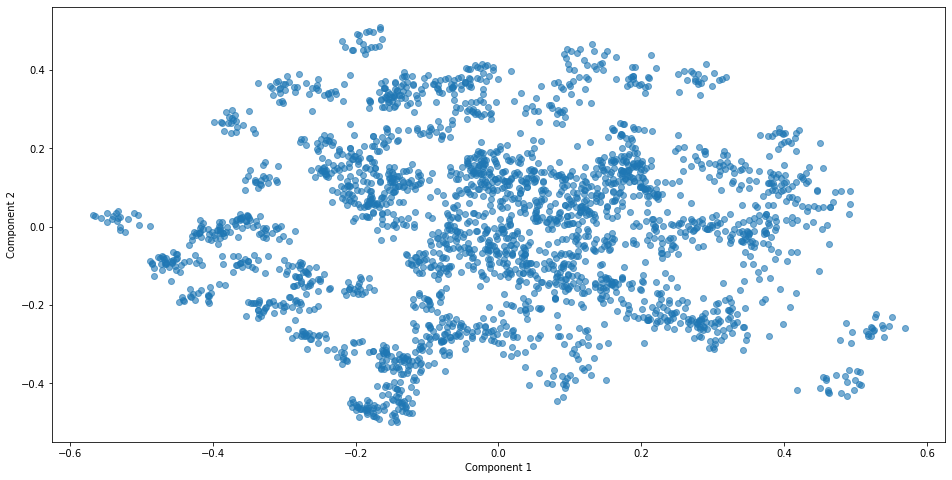

In [16]:
plot_manfold(model, data, 100, 20, "pca", "cosine")

# Geodesics Computation

In [17]:
! git clone https://github.com/MachineLearningLifeScience/stochman
! mv stochman stochman2
! mv  stochman2/stochman stochman
! rm -rf stochman2

Cloning into 'stochman'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 312 (delta 176), reused 233 (delta 108), pack-reused 0
Receiving objects: 100% (312/312), 469.11 KiB | 1.91 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [18]:
from stochman import utilities, manifold, geodesic

In [39]:
model = model.cpu()

In [115]:
class Geodesic(manifold.EmbeddedManifold):
    def __init__(self, decoder, **kwargs):
        super(Geodesic).__init__(**kwargs)
        self.decoder = decoder

    def embed(self, points, jacobian=False):
         return  torch.cat([torch.reshape(self.decoder(points[idx]), (points.shape[0], -1)).unsqueeze(0) for idx in range(points.shape[0])], 0)

In [120]:
geom = Geodesic(model.decoder)
X = next(iter(data))[0].cpu()
mu, log_var = model.encoder(X)
z  = torch.normal(mu, torch.exp(0.5*log_var)).cpu()

curve, success = geom.connecting_geodesic(z[:10], z[11:21])

In [159]:
# Parametrization Variable

a = torch.cat([torch.ones(10,1)*i/10 for i in range(11)], axis=1)

In [160]:
# Points over Geodesics in Latent Space

cp = curve.forward(a)

In [189]:
B, N, L = cp.shape

print(f"({B}, {N}, {L})")

(10, 11, 64)


In [191]:
# Generating Images corroponding to every geodesic.

img_along_geod = [model.decoder(cp[geod_idx]) for geod_idx in range(B)]

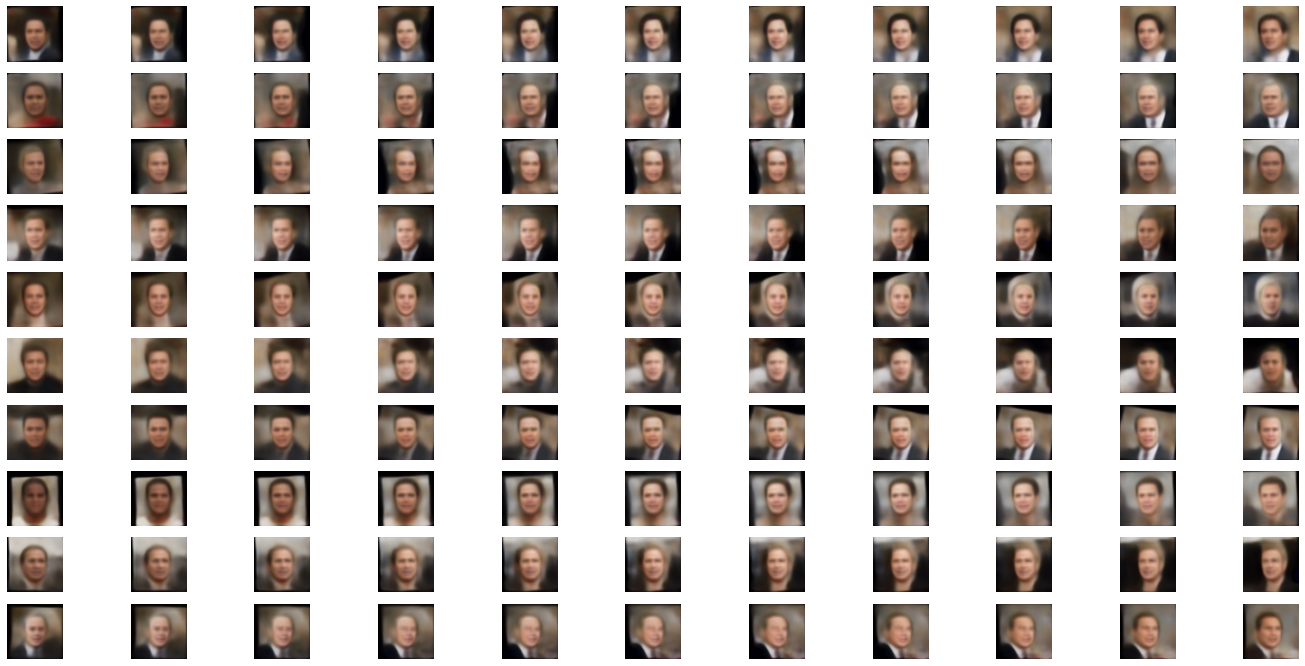

In [194]:
# Plotting Images along each geodesic. [Left to Right]

fig, ax = plt.subplots(B, N, figsize=(24, 12))
for j in range(B):
    for i in range(N):        
        ax[j, i].imshow(img_along_geod[j][i].transpose(0, 2).transpose(0, 1).detach().numpy())
        ax[j, i].axis('off')
plt.show()